In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
import sklearn.tree
import sklearn.ensemble
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
data_train_read = pd.read_csv("train.csv")
data_test_read = pd.read_csv("test.csv")

In [3]:
data_train = data_train_read.copy()

In [4]:
data_test = data_test_read.copy()

In [5]:
X_train = data_train[data_train.columns[1:len(data_train.columns) - 1]]
X_test = data_test[data_test.columns[1:]]
y_train = data_train['TARGET']

In [6]:
newX_train = X_train.copy()

# remove constant columns
colsToRemoveConst = []
for col in newX_train.columns:
    if newX_train[col].std() == 0:
        colsToRemoveConst.append(col)

newX_train.drop(colsToRemoveConst, axis=1, inplace=True)
X_test.drop(colsToRemoveConst, axis=1, inplace=True)


# remove duplicate columns
colsToRemove = []
columns = newX_train.columns
for i in range(len(columns)-1):
    v = newX_train[columns[i]].values
    for j in range(i+1,len(columns)):
        if np.array_equal(v, newX_train[columns[j]].values):
            colsToRemove.append(columns[j])
            
newX_train.drop(colsToRemove, axis=1, inplace=True)
X_test.drop(colsToRemove, axis=1, inplace=True)

X_train = pd.DataFrame(newX_train)

/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
random.seed(1337)
X_train_zeros = []
X_train_ones = []
X_tr_v = np.array(X_train.values)
for i in range(len(X_train)):
    if y_train[i] == 0:
        X_train_zeros.append(np.array(X_tr_v[i]))
    else:
        X_train_ones.append(np.array(X_tr_v[i]))

X_train_ones = np.array(X_train_ones)
X_train_zeros = np.array(X_train_zeros)

def get_matrix():
    res = []
    alpha = len(X_train_ones) / (1. * len(X_train_zeros))
    for i in range(len(X_train_zeros)):
        if random.random() < (alpha * .777):
            res.append(np.array([np.array(X_train_zeros[i]), 0]))
    for i in range(len(X_train_ones)):
        if random.random() < .777:
            res.append(np.array([np.array(X_train_ones[i]), 1]))
    random.shuffle(res)
    x = []
    y = []
    for i in res:
        x.append(i[0])
        y.append(i[1])
    x = np.array(x)
    y = np.array(y)
    return xgb.DMatrix(x, label=y)

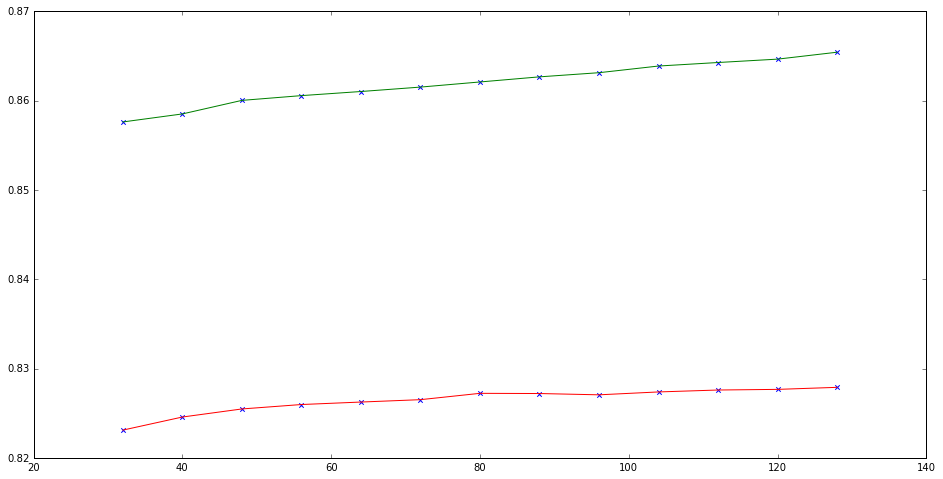

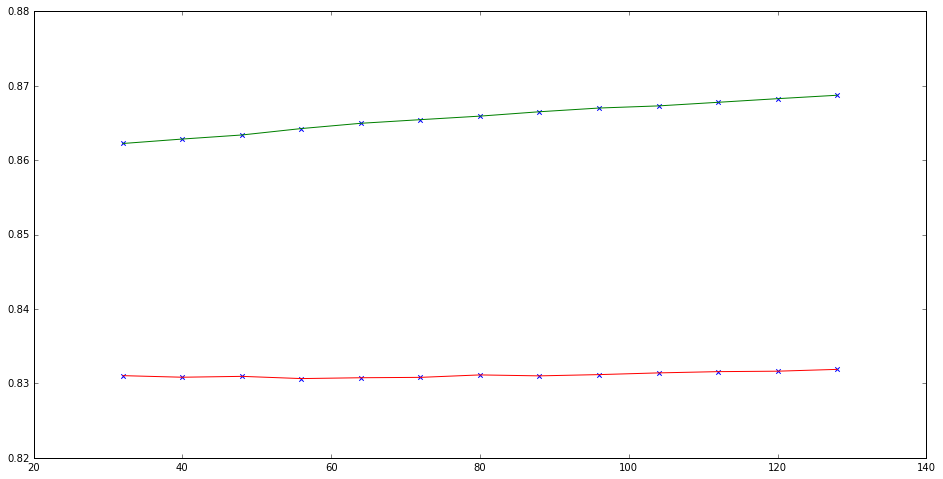

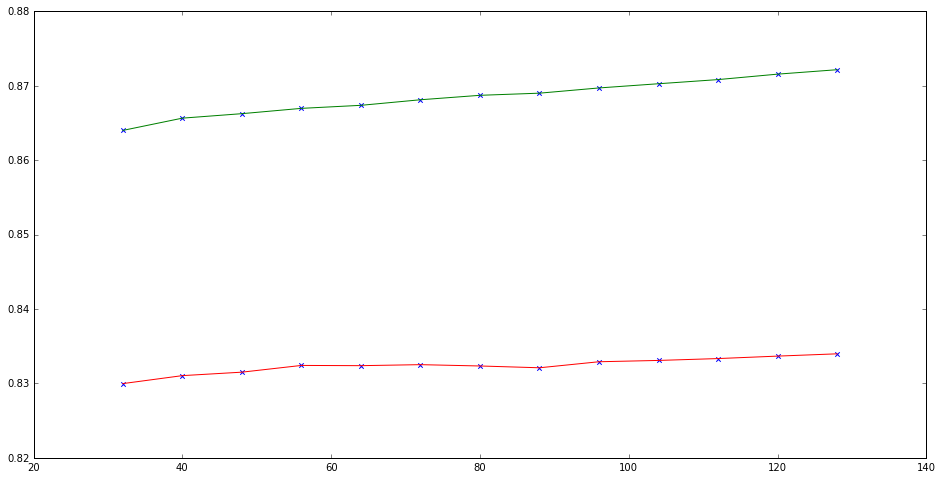

KeyboardInterrupt: 

In [16]:
params = {}  
params['objective']           = "binary:logistic" 
params['booster']             = "gbtree"
params['eval_metric']         = "auc"
params['eta']                 = 0.006
params['max_depth']           = 5
params['subsample']           = 0.681
params['colsample_bytree']    = 0.7

for current_plot_number in range(3):
    dtrain = get_matrix()
    x = np.arange(32, 129, 8)
    y1 = []
    y2 = []
    for nbr in x:
        score = xgb.cv(params=list(params.items()), dtrain=dtrain, num_boost_round=nbr)
        y1.append(score['test-auc-mean'][nbr - 1])
        y2.append(score['train-auc-mean'][nbr - 1])
    plt.figure(figsize=(16, 8))
    plt.plot(x, y1, color='r')
    plt.scatter(x, y1, marker='x')
    plt.plot(x, y2, color='g')
    plt.scatter(x, y2, marker='x')
    plt.show()
    

# num_boost_round=80 - для пацанов

In [ ]:
params = {}  
params['objective']           = "binary:logistic" 
params['booster']             = "gbtree"
params['eval_metric']         = "auc"
params['eta']                 = 0.006
params['max_depth']           = 5
params['subsample']           = 0.681
params['colsample_bytree']    = 0.7

ITERS = 45

preds = []
for i in range(ITERS):
    bst = xgb.train(params=list(params.items()), dtrain=get_matrix(), num_boost_round=80)
    preds.append(bst.predict(xgb.DMatrix(X_test)))
    print i

0
1
2
3
4
5
6
7
8
9


In [ ]:
y_test = [0.] * len(X_test)
for i in range(ITERS):
    for j in range(len(X_test)):
        y_test[j] += preds[i][j] / (1. * ITERS)
y_test = np.array(y_test)

In [ ]:
trash_count = 0
for i in range(len(y_test)):
    if y_test[i] < 0:
        y_test[i] = 0
        trash_count += 1
    if y_test[i] > 1:
        y_test[i] = 1
        trash_count += 1
print trash_count
ans = pd.DataFrame(index=data_test['ID'], data={'TARGET': y_test})
ans.to_csv('my_super_elite_submission_1337.csv')

In [ ]:
ans.describe()